**林野庁 森林資源の現況**

2007年, 2012年, 2017年

![](figures/2017_age_class_en.png)

-----


1. [パッケージの読み込み](#1/4-setup-パッケージの読み込み--)
2. [データのダウンロード](#2/4-setup-樹種別齢級別面積-データのダウンロード)
3. [データ整形](#3/4-input-森林現況-樹種別齢級別面積データ(xls)-の読み込み)
4. [データの確認](#4/4-eda-データの確認)

### <span class="badge">1/4</span> <span class="label label-primary">setup</span> パッケージの読み込み  <a class="anchor" id="pkg_load"></a>

In [1]:
library(dplyr)
library(assertr)
library(ensurer)
library(purrr)
library(ggplot2)
library(conflicted)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
conflict_prefer("filter", winner = "dplyr")
conflict_prefer("pluck", winner = "purrr")

[conflicted] Will prefer dplyr::filter over any other package
[conflicted] Will prefer purrr::pluck over any other package


<div class="alert alert-info" role="alert">
    <strong>Check!</strong> filter()はR標準の関数名と衝突するため、dplyrパッケージのfilter()を優先して利用するようにする。<br>
    <a href="https://uribo.hatenablog.com/entry/2018/09/29/103632" class="alert-link">参考ページ</a>
</div>

### <span class="badge">2/4</span> <span class="label label-primary">setup</span> 樹種別齢級別面積 データのダウンロード


<div class="alert alert-warning alert-dismissible" role="alert">
  <button type="button" class="close" data-dismiss="alert" aria-label="Close"><span aria-hidden="true">&times;</span></button>   
一度データを保存しておけば実行されないように条件分岐で調整
</div>

In [3]:
if (length(fs::dir_ls(here::here("data-raw"), regexp = "genkyo_[0-9]{4}.xls")) != 3L) {

  library(rvest)

  # 1/2 ダウンロードするファイルURLを得る -------------------------
  site_url <-
    "http://www.rinya.maff.go.jp/"

  target_url <-
    glue::glue(site_url, "j/keikaku/genkyou/index1.html")

  year_links <-
    read_html(target_url) %>%
    html_nodes(css = '#main_content > h3 > a') %>% # nolint
    html_attr("href") %>%
    # 3ヶ年が選ばれているか
    ensure(length(.) == 3L) %>%
    map_chr(
      ~ read_html(.x) %>%
        html_nodes('#main_content > h3 > a') %>%
        # 樹種別齢級別面積のリンク先のURLを得る
        keep(
          ~ stringr::str_detect(html_text(.x), "樹種別齢級別面積")) %>%
        html_attr(name = "href")) %>%
    ensure(length(.) == 3L) %>%
    # データの公開年をファイル名に使うため
    set_names(
      stringr::str_extract(., "h[1-2]{1}[0-9]{1}"))

  dl_links <-
    year_links %>%
    map_chr(
      ~ read_html(.x) %>%
        html_nodes(css = '#main_content > p > a') %>% # nolint
        keep(
          ~ stringr::str_detect(html_text(.x), "全データダウンロード")) %>%
        html_attr("href") %>%
        xml2::url_absolute(.x)) %>%
    ensure(length(.) == 3L)

  # 2/2 data-rawフォルダにダウンロード ------------------------------
  dl_links %>%
    walk2(
      .y = names(dl_links),
      .f = ~
        curl::curl_download(.x,
                            destfile = glue::glue("data-raw/genkyo_{year}.",
                                                  # ファイル形式を取得 hoge.xls --> xls
                                                  tools::file_ext(.x),
                                                  # 和暦から西暦へ H29 --> 2017
                                                  year = odkitchen::convert_jyr(.y))))
}


### <span class="badge">3/4</span> <span class="label label-success">input</span> 森林現況 樹種別齢級別面積データ(xls) の読み込み

In [4]:
input_csv <-
  fs::dir_ls(here::here("data"), regexp = "[0-9]{4}_genkyo_conifer_age_class.csv$")

if (length(input_csv) != 3) {

  source(here::here("data-raw/download_genkyo.R"))

  library(readxl)
  library(dplyr)
  source(here::here("R/read_genkyo_xls.R"))

  # 1/2 人工林スギ、人工林ヒノキを対象にする --------------------------------------------------
  input_xls <-
    fs::dir_ls(here::here("data-raw"), regexp = "genkyo_[0-9]{4}.xls")

  target_sheet_index <-
    input_xls %>%
    purrr::map(
      ~ excel_sheets(.x) %>%
        # ref) issue#4
        # 人工林スギ、人工林ヒノキをエスケープ
        stringr:::str_which("\\A\\u4eba\\u5de5\\u6797(\\u30b9\\u30ae\\uff9e|\\u30b9\\u30ae|\\u30d2\\u30ce\\u30ad)\\z") %>%
        ensure(length(.) == 2L)
    ) %>%
    # シート位置が共通なのでユニークにする
    flatten_dbl() %>%
    unique()

  # read_genkyo_xls(input_xls[3], sheet_index = target_sheet_index[2]) %>%
  #   verify(dim(.) == c(47, 22))

  # 2/2 ファイル、シートの組み合わせでデータを読み込む ---------------------------------------------
  input_sets <-
    list(
      input_xls,
      target_sheet_index) %>%
    cross()

  df_conifer_age <-
    input_sets %>%
    map_dfr(lift(read_genkyo_xls, tidy = TRUE)) %>%
    # 行数: 47都道府県 * 組み合わせ数(ファイル、シート) * age列数
    verify(dim(.) == c(47 * length(input_sets) * 19, 5))

  df_conifer_age %>%
    count(target) %>%
    verify(nrow(.) == 2L) %>%
    invisible()

  if (rlang::is_false(dir.exists(here::here("data"))))
    dir.create(here::here("data"))

  df_conifer_age %>%
    group_by(year) %>%
    group_walk(~ readr::write_csv(.x,
                                  path = here::here("data", stringr::str_c(.y$year, "_genkyo_conifer_age_class.csv"))))
} else {
  df_conifer_age <-
    input_csv %>%
    map_dfr(~ readr::read_csv(.x) %>%
              dplyr::transmute(year = readr::parse_number(basename(.x)),
                               target,
                               prefecture,
                               age,
                               value)) %>%
    verify(dim(.) == c(5358, 5)) %>%
    dplyr::mutate(age = forcats::fct_inorder(age))
}

Parsed with column specification:
cols(
  target = col_character(),
  prefecture = col_character(),
  age = col_character(),
  value = col_double()
)
Parsed with column specification:
cols(
  target = col_character(),
  prefecture = col_character(),
  age = col_character(),
  value = col_double()
)
Parsed with column specification:
cols(
  target = col_character(),
  prefecture = col_character(),
  age = col_character(),
  value = col_double()
)


### <span class="badge">4/4</span> <span class="label label-info">eda</span> データの確認

In [5]:
df_conifer_age %>%
      count(year, target, prefecture)

year,target,prefecture,n
<dbl>,<chr>,<chr>,<int>
2007,人工林スギ,愛知県,19
2007,人工林スギ,愛媛県,19
2007,人工林スギ,茨城県,19
2007,人工林スギ,岡山県,19
2007,人工林スギ,沖縄県,19
2007,人工林スギ,岩手県,19
2007,人工林スギ,岐阜県,19
2007,人工林スギ,宮崎県,19
2007,人工林スギ,宮城県,19


In [6]:
missing_counts =
      df_conifer_age %>%
      summarise_all(list(~ sum(is.na(.))))

label_key: age


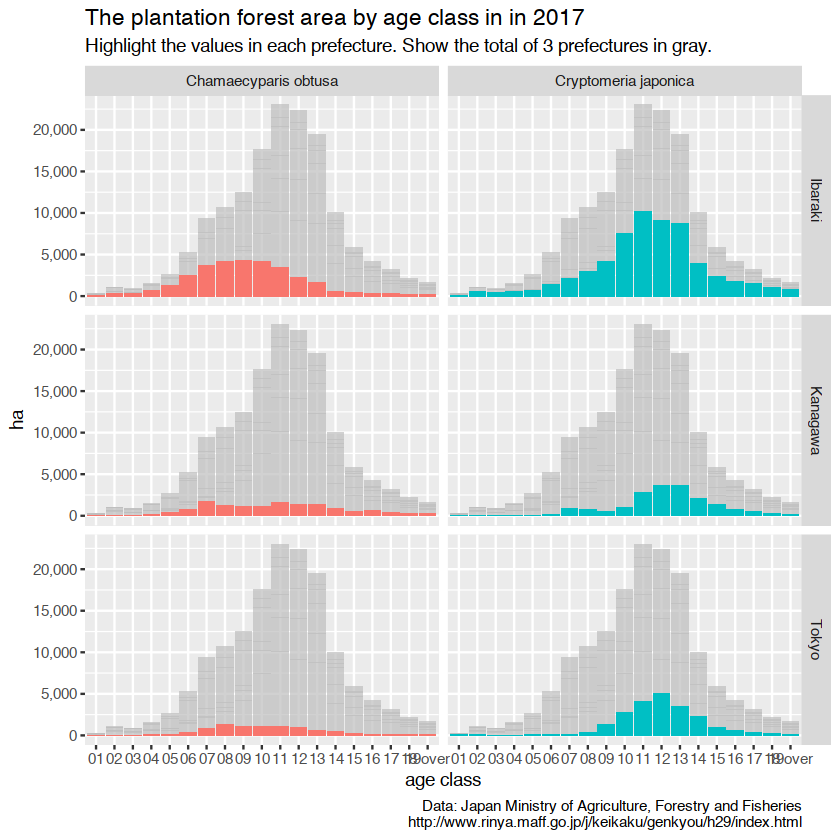

In [7]:
df_conifer_age %>%
  filter(year == 2017,
         prefecture %in% c("東京都", "神奈川県", "茨城県")) %>%
  mutate(age = stringr::str_pad(stringr::str_remove_all( age, "age_"), width = 2, pad = "0")) %>%
  mutate(target = recode(target,
                         `人工林スギ` = "Cryptomeria japonica",
                         `人工林ヒノキ` = "Chamaecyparis obtusa"),
         prefecture = recode(prefecture,
                             `茨城県` = "Ibaraki",
                             `神奈川県` = "Kanagawa",
                             `東京都` = "Tokyo")) %>%
  ggplot(aes(age, value, fill = target)) +
  geom_bar(stat = "identity") +
  gghighlight::gghighlight() +
  theme(strip.text = element_text(face = "italic")) +
  facet_grid(prefecture ~ target) +
  guides(fill = FALSE) +
  scale_y_continuous(labels = scales::comma) +
  labs(x = "age class",
       y = "ha",
       title = "The plantation forest area by age class in in 2017",
       subtitle = "Highlight the values in each prefecture. Show the total of 3 prefectures in gray.",
       caption = "Data: Japan Ministry of Agriculture, Forestry and Fisheries\nhttp://www.rinya.maff.go.jp/j/keikaku/genkyou/h29/index.html")